## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.75]
redice_lr_patient = [8]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(min_lr=1e-12, 
                                  monitor='val_loss', 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0728 17:56:45.216250 140735685370752 deprecation_wrapper.py:119] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 17:56:45.217585 140735685370752 deprecation_wrapper.py:119] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 17:56:45.221987 140735685370752 deprecation_wrapper.py:119] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 17:56:45.342858 140735685370752 deprecation_wrapper.py:119] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Pleas

Numbers of exp: 0, reduce_factor: 0.75, reduce_patient: 8


W0728 17:56:45.549125 140735685370752 deprecation_wrapper.py:119] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 17:56:45.559175 140735685370752 deprecation_wrapper.py:119] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0728 17:56:45.665925 140735685370752 deprecation.py:323] From /Users/linyongcheng/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 6s 116us/step - loss: 0.8005 - acc: 0.7473 - val_loss: 1.4842 - val_acc: 0.5026
Epoch 49/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.8004 - acc: 0.7477 - val_loss: 1.4845 - val_acc: 0.5029

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 50/50
50000/50000 [==============================] - 6s 115us/step - loss: 0.7998 - acc: 0.7468 - val_loss: 1.4845 - val_acc: 0.5034
Numbers of exp: 1, reduce_factor: 0.75, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048

Epoch 44/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.3565 - acc: 0.9085 - val_loss: 1.5387 - val_acc: 0.5323
Epoch 45/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.3576 - acc: 0.9090 - val_loss: 1.5390 - val_acc: 0.5323
Epoch 46/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.3567 - acc: 0.9091 - val_loss: 1.5393 - val_acc: 0.5319
Epoch 47/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.3570 - acc: 0.9089 - val_loss: 1.5396 - val_acc: 0.5324
Epoch 48/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.3566 - acc: 0.9091 - val_loss: 1.5398 - val_acc: 0.5321
Epoch 49/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.3570 - acc: 0.9095 - val_loss: 1.5400 - val_acc: 0.5328
Epoch 50/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.3561 - acc: 0.9093 - val_loss: 1.5404 - val_acc: 0.5327
Numbers of exp: 2, reduce_f

Epoch 41/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.3509 - acc: 0.9077 - val_loss: 1.5682 - val_acc: 0.5418
Epoch 42/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.3492 - acc: 0.9087 - val_loss: 1.5698 - val_acc: 0.5424
Epoch 43/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.3477 - acc: 0.9088 - val_loss: 1.5743 - val_acc: 0.5413
Epoch 44/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.3467 - acc: 0.9097 - val_loss: 1.5751 - val_acc: 0.5427
Epoch 45/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.3463 - acc: 0.9095 - val_loss: 1.5752 - val_acc: 0.5419
Epoch 46/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.3470 - acc: 0.9089 - val_loss: 1.5770 - val_acc: 0.5416
Epoch 47/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.3453 - acc: 0.9100 - val_loss: 1.5793 - val_acc: 0.5430

Epoch 00047: ReduceLROnPla

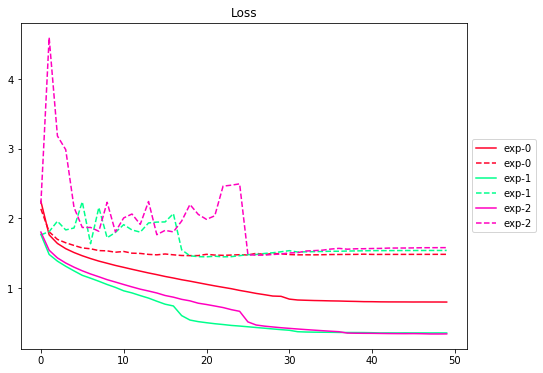

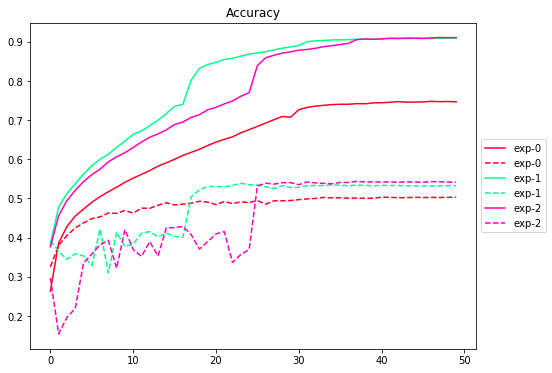

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()